# Graph extraction with Gemini and SurrealDB

This notebook demonstrates the process of extracting a knowledge graph from unstructured text and storing it in the SurrealDB database. The process involves several steps:

### Data Loading: 
    Loads the raw text data from which the knowledge graph will be extracted.


### Using an LLM (in this example Gemini) for:

#### Entity Recognition: 
    Identifies and extracts key entities (people, organizations, locations, etc.) from the text. 

#### Relationship Extraction:
    Determines relationships between the extracted entities. 


### Constructing the Knowledge Graph with Surreal: 
    Converts the extracted entities and relationships into a knowledge graph stored in SurrealDB. This involves:

        Mapping entities to nodes and relationships to edges in the graph.

        Using SurrQL statements (CREATE for nodes, RELATE for edges) to populate the knowledge graph in the database.


### Connecting to SurrealDB:
    Establishes a connection to the SurrealDB instance. This  involves:

        Specifying the connection parameters (e.g., ws://localhost:8000/rpc).

        Authenticating with the database using credentials (e.g., username and password).

        Selecting the appropriate namespace for the knowledge graph.



### Generating and Storing Embeddings: 
    Improves semantic search capabilities within the knowledge graph by:

        Using an embedding model (glove.6B.50d in this example) to generate numerical representations of entities and relationships.

        Storing these embeddings as properties of the nodes and edges in SurrealDB, allowing for similarity-based searches.


### Visualizing the graph:
    We use the networkx library to render the graph visually that has been stored in SurreaDB


This notebook utilizes libraries :
    surrealdb to interact with SurrealDB
    google.generativeai to interact with Gemini
    networkx to visualize the graph

The notebook is loosely based on a larger repository microsoft/graphrag. The microsoft/graphrag repository provides a more comprehensive, modular graph-based RAG system. This notebook focuses specifically on the knowledge graph construction aspect.


In [1]:
import sys
import os
import json
import google.generativeai as genai
import os
import time
import ipynb_path
from surrealdb import Surreal;
import pandas as pd

#get this notebook's path for access to the other files needed
dir_path = os.path.dirname(os.path.realpath(ipynb_path.get(__name__)))
sys.path.append(dir_path) #add the current directory for adding py imports
from prompts import CONTINUE_PROMPT, GRAPH_EXTRACTION_PROMPT, LOOP_PROMPT


In [2]:

# this folder
nb_folder = dir_path
out_folder = nb_folder + "/{0}".format(time.strftime("%Y%m%d-%H%M%S"))

os.makedirs(out_folder, exist_ok=True)


input_file = nb_folder + "/Operation Dulce v2 1 1.md"
prompt_file = out_folder + "/test_prompt.txt"
surql_file = out_folder + "/inserts.suql"
chat_file = out_folder + "/chat.json"



# make sure to start deliminater with # to escape it in SQL
COMPLETION_DELEMITER = "#XXXXXXCOMPLETEXXXXXX" 
MAX_RETRIES = 10

# get the text from the source file to create a knowledge graph of 
with open(input_file, "r") as f:
    input_text = f.read()

entity_types = ["PERSON", "PLACE"]
relation_type = "RELATED_TO"

# entity types should be the objects that you will find in the document
# each entity type listed will create tables of the same name
# the relate table will be names relation_type
sql_gen_prompt = GRAPH_EXTRACTION_PROMPT.format(
    entity_types = ",".join(entity_types),
    record_delimiter = ";\n",
    completion_delimiter = COMPLETION_DELEMITER,
    input_text = input_text,
    relation_type = relation_type
        )

# log the initial prompt in a file
with open(prompt_file, "w") as f:
    f.write(sql_gen_prompt)



In [3]:

# this function will recursively call a prompt until
# the prompt ends with the COMPLETION_DELIMINATER 
# or exceeds the max number of tries
def generate_content_until_complete(the_model,the_messages,retry_count):
    time.sleep(5) # to stop generating too many requests per min
    response = the_model.generate_content(the_messages)
    ai_response_text = response.text
    
    #confirm the response ends with the correct delemiter
    if ai_response_text.strip().endswith(COMPLETION_DELEMITER):
        return response
    else:
        retry_count = retry_count + 1
        if retry_count > MAX_RETRIES:
            raise Exception("Too many retries {0}".format(retry_count))
        else:
            #try again!
            return generate_content_until_complete(the_model,the_messages,retry_count)
    
        

In [4]:


# Set your API key (I've stored mine in an env variable)
genai.configure(api_key=os.getenv('GOOGLE_GENAI_API_KEY'))

#flash is faster and good enough
#model = "gemini-1.0-pro"
model = "gemini-1.5-flash"

model = genai.GenerativeModel(model)

#messages is the array that stores the entire chat history
#it will need to be amended with each exchange with the LLM
#the LLM will receive this with the new prompts each time to maintain session/memory
messages = [
            {"role": "user", "parts": [{"text": sql_gen_prompt}]}
        ]


print("fetching the graph ...")
response = generate_content_until_complete(model,messages,1)
ai_response = response.text

#add the response to the chat history
messages.append({"role": "model", "parts": [{"text": ai_response}]})

#surql will store the DML statements to execute
surql = ai_response

# execute this loop while LLM decries there are more relations to decipher
# and the the iterations doesn't exceed our threshold 
more_relations = True
i = 0


#logging
with open(chat_file, "w") as f:
    json.dump(messages, f)
with open(surql_file, "w") as f:
    f.write(surql)

while more_relations and i<MAX_RETRIES:
    i = i + 1
    print("fetching more relations N={0}... ".format(i), end="")

    #ask the LLM if it missed anything
    messages.append({"role": "user", "parts": [{"text": LOOP_PROMPT}]})

    response = model.generate_content(messages)
    ai_response = response.text.strip()
    
    messages.append({"role": "model", "parts": [{"text": ai_response}]})

    
    more_relations = (ai_response == "YES")
    print(" continue? {0}".format(ai_response))
     
    # if the LLM responds with yes then we will ask it for more
    if(more_relations):
        
        # ask the LLM to add more relations and objects that it said it missed
        messages.append({"role": "user", "parts": [{"text": CONTINUE_PROMPT}]})
        
        response = generate_content_until_complete(model,messages,1)
         
        ai_response = response.text
        
        messages.append({"role": "model", "parts": [{"text": ai_response}]})

        surql = surql + ai_response

    
    with open(chat_file, "w") as f:
        json.dump(messages, f)
        
    with open(surql_file, "w") as f:
        f.write(surql)
        



fetching the graph ...
fetching more relations N=1...  continue? YES
fetching more relations N=2...  continue? YES
fetching more relations N=3...  continue? YES
fetching more relations N=4...  continue? YES
fetching more relations N=5...  continue? YES
fetching more relations N=6...  continue? YES
fetching more relations N=7...  continue? YES
fetching more relations N=8...  continue? YES
fetching more relations N=9...  continue? YES
fetching more relations N=10...  continue? NO


In [5]:

#now we have our surQL code to execute so let's connect make sure our database is up and running

ip = "0.0.0.0:8080"
url = "ws://{0}/rpc".format(ip)

u = "root"
p = "root"
n = "graph_rag"
d = "graph_rag"
db_folder = nb_folder + "/db"

surrealdb_start = "surreal start --allow-net --log none --user {u} --pass {p} --bind {ip} \"rocksdb://{db_folder}\"".format(
    u=u,
    p=p,
    ip=ip,
    db_folder=db_folder)

#run this command if your surreal instance isn't running yet 
#copy and paste from below into a terminal
print(surrealdb_start)

     

surreal start --allow-net --log none --user root --pass root --bind 0.0.0.0:8080 "rocksdb:///Users/sandro/Library/CloudStorage/GoogleDrive-apireno@gmail.com/My Drive/code/graph_rag/db"


In [15]:


#drop the data from any previous run and re-create the ns and db
recreate_db_surql = """
DEFINE NAMESPACE OVERWRITE {0};
DEFINE DATABASE OVERWRITE {1};
"""


#create the function that will do calculate embeddings
#this is hosted on an api running locally BYOE or use a hosted one as you see fit
embedding_function_surql = """
DEFINE FUNCTION IF NOT EXISTS fn::get_embeddings($text: string) {
	RETURN http::post('http://127.0.0.1:5000/', {
      "text":  $text
    });
};
"""

#this DDL will create the entity tables
recreate_table_surql = """
REMOVE TABLE IF EXISTS {0};
DEFINE TABLE {0} SCHEMAFULL;
DEFINE FIELD description ON TABLE {0} TYPE string;
DEFINE FIELD embedding ON TABLE {0} TYPE option<array<float>> 
    VALUE fn::get_embeddings( description);
"""


#this DDL will create the relation table
recreate_relate_table_surql = """
REMOVE TABLE IF EXISTS {relation_type};
DEFINE TABLE {relation_type} SCHEMAFULL TYPE RELATION FROM {entity_type1} TO {entity_type1}|{entity_type2};
DEFINE FIELD description ON TABLE {relation_type} TYPE string;
DEFINE FIELD strength ON TABLE {relation_type} TYPE int;
DEFINE FIELD embedding ON TABLE {relation_type} TYPE option<array<float>> 
    VALUE fn::get_embeddings(description);
"""

#this is a sample query after inserts
sample_query = """

SELECT id,description, ->{relation_type}.{{out,strength,description}} FROM {entity_type} 

        """
#this will pull all the entities for displaying in a diagram later
entity_query = "SELECT * FROM {entity_type}"
#this will pull all the relations for displaying in a diagram later
relation_query = "SELECT * FROM {relation_type}"



async with Surreal(url) as db:
    await db.signin({"user": u, "pass": p})    
    outcome = await db.query(recreate_db_surql.format(n,d))
    await db.use(n, d)
    outcome = await db.query(embedding_function_surql)
    outcome = await db.query(recreate_table_surql.format(entity_types[0]))
    outcome = await db.query(recreate_table_surql.format(entity_types[1]))
    
    outcome = await db.query(recreate_relate_table_surql.format(relation_type = relation_type, entity_type1 = entity_types[0], entity_type2 = entity_types[1]))

    
    outcome = await db.query(surql)
    sample_query_outcome = await db.query(sample_query.format(relation_type = relation_type, entity_type = entity_types[0]))
    entity_query_outcome1 = await db.query(entity_query.format(entity_type = entity_types[0]))
    entity_query_outcome2 = await db.query(entity_query.format(entity_type = entity_types[1]))
    relation_query_outcome = await db.query(relation_query.format(relation_type = relation_type))
    
df = pd.json_normalize(sample_query_outcome[0]["result"])  
edf1 = pd.json_normalize(entity_query_outcome1[0]["result"])  
edf2 = pd.json_normalize(entity_query_outcome2[0]["result"]) 
rdf = pd.json_normalize(relation_query_outcome[0]["result"])

df.head

       

<bound method NDFrame.head of                                         ->RELATED_TO  \
0  [{'description': 'Alex Mercer and Jordan Hayes...   
1  [{'description': 'Jordan Hayes and Sam Rivera ...   
2  [{'description': 'Sam Rivera is using their te...   
3  [{'description': 'Taylor Cruz is a member of t...   
4  [{'description': 'The unknown intelligence is ...   

                                         description                     id  
0  Agent Alex Mercer is a member of the Paranorma...   PERSON:⟨ALEX MERCER⟩  
1  Dr. Jordan Hayes is a member of the Paranormal...  PERSON:⟨JORDAN HAYES⟩  
2  Sam Rivera is a member of the Paranormal Milit...    PERSON:⟨SAM RIVERA⟩  
3  Agent Taylor Cruz is a member of the Paranorma...   PERSON:⟨TAYLOR CRUZ⟩  
4  The unknown alien intelligence behind the sign...         PERSON:UNKNOWN  >

In [7]:


#this function parses out the nested list that contains the relations in this query
def format_nested_array(x):
    if isinstance(x, list):
        
        return "<br>".join(str(item["out"]) + "-" + str(item["strength"]) for item in x) 
    return x

#reorder the columns 
df2 = df.iloc[:,[2,1,0]]

#print the sample query
df2.style.format({"->RELATED_TO": format_nested_array})





,id,description,->RELATED_TO
0,PERSON:⟨ALEX MERCER⟩,Agent Alex Mercer is a member of the Paranormal Military Squad who is responsible for overseeing the team's mission to understand and communicate with an alien signal,PERSON:⟨TAYLOR CRUZ⟩-8PLACE:COSMOS-6PLACE:HUMANITY-8PLACE:⟨COSMIC COMMUNITY⟩-7PERSON:⟨SAM RIVERA⟩-7PERSON:⟨JORDAN HAYES⟩-9PLACE:⟨COMMAND CENTER⟩-9PLACE:DULCE-9
1,PERSON:⟨JORDAN HAYES⟩,"Dr. Jordan Hayes is a member of the Paranormal Military Squad, specializing in deciphering alien signals and working on interpreting their meaning",PLACE:⟨COSMIC COMMUNITY⟩-7PERSON:⟨SAM RIVERA⟩-8PLACE:HUMANITY-8PLACE:DULCE-9PERSON:⟨TAYLOR CRUZ⟩-6PLACE:⟨COMMAND CENTER⟩-9PLACE:COSMOS-6
2,PERSON:⟨SAM RIVERA⟩,"Sam Rivera is a member of the Paranormal Military Squad, skilled in technology and deciphering alien communications",PLACE:⟨COSMIC COMMUNITY⟩-7PLACE:COSMOS-6PLACE:DULCE-9PLACE:HUMANITY-8PLACE:⟨COMMAND CENTER⟩-9
3,PERSON:⟨TAYLOR CRUZ⟩,"Agent Taylor Cruz is a member of the Paranormal Military Squad, known for their strict adherence to protocol and their cautious approach to the alien signals",PLACE:COSMOS-6PLACE:⟨COMMAND CENTER⟩-9PLACE:DULCE-9PLACE:⟨COSMIC COMMUNITY⟩-7PERSON:⟨SAM RIVERA⟩-7PLACE:HUMANITY-8
4,PERSON:UNKNOWN,"The unknown alien intelligence behind the signal, possessing advanced communication technology",PERSON:⟨TAYLOR CRUZ⟩-8PLACE:SIGNAL-9PLACE:EARTH-9PLACE:COSMOS-10PERSON:⟨ALEX MERCER⟩-8PLACE:⟨INTERSTELLAR SPACE⟩-9PLACE:⟨DULCE BASE⟩-8PLACE:⟨COSMIC COMMUNITY⟩-8PERSON:⟨JORDAN HAYES⟩-8PLACE:⟨GALACTIC COMMUNITY⟩-8PLACE:HUMANITY-9PERSON:⟨SAM RIVERA⟩-8


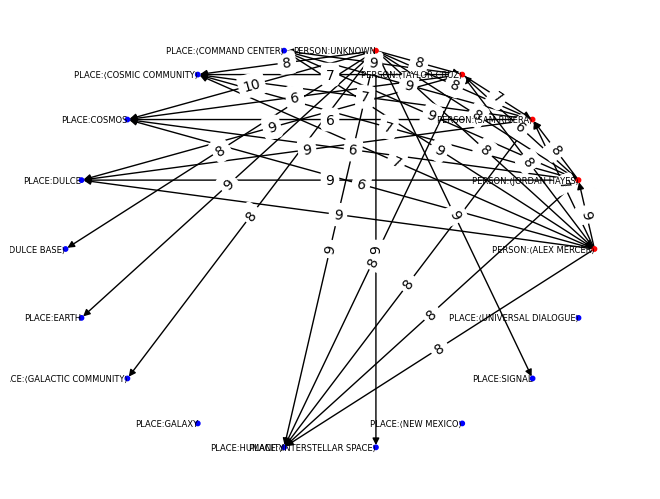

In [37]:
#let's visualize the graph

import networkx as nx
import matplotlib.pyplot as plt



# Create a graph
G = nx.DiGraph()

#add a node for each entity
for index, row in edf1.iterrows():
    G.add_node(row['id'], entity_type=entity_types[0])
for index, row in edf2.iterrows():
    G.add_node(row['id'],  entity_type=entity_types[1])


#add an edge for each relationship
for index, row in rdf.iterrows():
    G.add_edge(row['in'],row['out'],label=row["strength"])

#generate a color map for rendering the nodes
color_map = nx.get_node_attributes(G,"entity_type")
for key in color_map:
    if color_map[key] == entity_types[0]:
        color_map[key] = "red"
    else:
        color_map[key] = "blue"

entity_colors = [color_map.get(node) for node in G.nodes]




# Draw the graph
#pos = nx.spring_layout(G)  # Use spring layout for node positioning
#pos=nx.fruchterman_reingold_layout(G)
pos=nx.circular_layout(G)
#pos=nx.random_layout(G)
#pos=nx.spectral_layout(G)
nx.draw(G, pos, with_labels=True, node_size=10, font_size=6, node_color=entity_colors,
       horizontalalignment='right')
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
plt.show()





In [11]:

df

,->RELATED_TO,description,id
0,[{'description': 'Alex Mercer and Taylor Cruz ...,Agent Alex Mercer is a member of the Paranorma...,PERSON:⟨ALEX MERCER⟩
1,[{'description': 'Jordan Hayes is working on d...,Dr. Jordan Hayes is a member of the Paranormal...,PERSON:⟨JORDAN HAYES⟩
2,[{'description': 'Sam Rivera is using their te...,Sam Rivera is a member of the Paranormal Milit...,PERSON:⟨SAM RIVERA⟩
3,"[{'description': 'Taylor Cruz, as a leader in ...",Agent Taylor Cruz is a member of the Paranorma...,PERSON:⟨TAYLOR CRUZ⟩
4,[{'description': 'The unknown intelligence is ...,The unknown alien intelligence behind the sign...,PERSON:UNKNOWN


In [73]:
recreate_relate_table_surql.format(relation_type = relation_type, entity_type1 = entity_types[0], entity_type2 = entity_types[1])

'\nREMOVE TABLE IF EXISTS RELATED_TO;\nDEFINE TABLE RELATED_TO SCHEMAFULL TYPE RELATION IN [PERSON,PLACE] OUT [PERSON,PLACE];\nDEFINE FIELD description ON TABLE RELATED_TO TYPE string;\nDEFINE FIELD strength ON TABLE RELATED_TO TYPE int;\nDEFINE FIELD embedding ON TABLE RELATED_TO TYPE option<array<float>> \n    VALUE fn::get_embeddings(description);\n'